In [2]:
import numpy as np
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import time
import scipy
from scipy.spatial import distance_matrix


In [3]:
print("teste")

teste


In [5]:
def roots_function(mat_x_y):
    x = mat_x_y[:, 0]
    y = mat_x_y[:, 1]
    z = x + 1j*y
    g = 1 / (1 + np.abs(z**6 - 1))
    return g

In [6]:
def schaffer_function(mat_x_y):
    x = mat_x_y[:, 0]
    y = mat_x_y[:, 1]
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

In [27]:
class OptAiNet():
    def __init__(self,
                 num_epochs:int,
                 pop_size:int,
                 Nc:int,
                 chrom_length:int,
                 value_ranges:list,
                 fitness_func, # Function Type,
                 beta=100,
                 clone_threshold = 0.1,
                 supression_threshold=0.2,
                 newcomers_percentage = 0.4,
                 seed=42,
                 eval_every=100,
                 verbose = 0,
                ):
        
        self.num_epochs = num_epochs
        self.pop_size = pop_size
        self.value_ranges = np.array(value_ranges)
        self.fitness_func = fitness_func
        self.chrom_length = chrom_length
        self.Nc = Nc
        self.beta = beta
        self.clone_threshold = clone_threshold
        self.supression_threshold = supression_threshold
        self.newcomers_percentage = newcomers_percentage

        self.f_pop_avg_previous = 0
        self.continue_clone = True

        self.seed = seed    
        self.best_ind_list = np.zeros(self.num_epochs)
        self.avg_ind_list = np.zeros(self.num_epochs)
        self.eval_every = eval_every
        self.verbose = verbose
        np.random.seed(seed=seed)

        self.max_fitness = 0
        self.min_fitness = 1

        #self.init_pop()
        #self.fitness_evaluation()
        #self.clone()
        #self.mutation()
        #self.fitness_evaluation()
        #self.evaluation()
        #self.supress_cells()
        #self.add_newcomers()


    
    def init_pop(self):
        self.pop = np.random.rand(self.pop_size, self.chrom_length)
        self.min_mat = self.value_ranges.T[0, :]
        self.max_mat = self.value_ranges.T[1,:]
        self.pop = self.pop * (self.max_mat - self.min_mat) + self.min_mat
        #self.f_pop = self.fitness_func(self.pop)
    
    def fitness_evaluation(self):
        self.f_pop = self.fitness_func(self.pop)
        self.curr_f_max = self.f_pop.max()
        self.curr_f_min = self.f_pop.min()

        if self.max_fitness < self.curr_f_max:
            self.max_fitness = self.curr_f_max
        if self.min_fitness > self.curr_f_min:
            self.min_fitness = self.curr_f_min

        self.f_pop_norm = (self.f_pop - self.min_fitness)/(self.max_fitness - self.min_fitness)
        return
    
    def clone(self):
        self.pop = np.repeat(self.pop, repeats=self.Nc + 1, axis=0)
        self.f_pop_norm = np.repeat(self.f_pop_norm, repeats=self.Nc + 1, axis=0)

    def mutation(self):
        self.alpha = (1/self.beta) * np.exp(-self.f_pop_norm)
        self.random_mutation = np.random.normal(0, 1, size=self.pop.shape[0] * self.pop.shape[1])
        self.random_mutation = self.random_mutation.reshape(self.pop.shape[0], self.pop.shape[1])
        mask = np.zeros(self.random_mutation.shape[0], dtype=bool)
        mask[::self.Nc + 1] = True
        self.random_mutation[mask,:] = 0
        self.alpha = np.repeat(self.alpha, self.chrom_length)

        self.alpha = self.alpha.reshape(self.random_mutation.shape)
        self.pop = self.pop + self.alpha * self.random_mutation
        # Still needs to add a way to invalidate a individual in a positsion outside of the searhc spacie

    def evaluation(self):
        self.f_pop_avg = self.f_pop.mean()
        mean_error = np.abs(self.f_pop_avg - self.f_pop_avg_previous)
        if  mean_error < self.clone_threshold:
            self.continue_clone = False
        else:
            self.continue_clone = True
        self.f_pop_avg_previous = self.f_pop_avg
    
    def supress_cells(self):
        distances = distance_matrix(self.pop, self.pop)        
        f_pop_matrix = np.tile(self.f_pop, (distances.shape[0], 1)) 
        masked_f = f_pop_matrix * (distances<self.supression_threshold)
        best_indices = np.where(masked_f == masked_f.max(axis=1).T)[1]
        best_indices = np.unique(best_indices)
        self.pop = self.pop[best_indices]
        self.f_pop = self.f_pop[best_indices]
        self.best_ind = self.pop.copy()
        self.best_fits = self.f_pop.copy()
    
    def add_newcomers(self):
        n_new_ind = int(len(self.pop) * self.newcomers_percentage)
        if n_new_ind == 0:
            n_new_ind = 1
        newcomers = np.random.rand(n_new_ind, self.chrom_length)
        newcomers = newcomers * (self.max_mat - self.min_mat) + self.min_mat
        self.pop = np.append(self.pop, newcomers, axis=0)

    def callback(self):
        max_val = np.max(self.f_pop)
        mean_val = np.mean(self.f_pop)
        self.best_ind_list[self.curr_epoch] = max_val
        self.avg_ind_list[self.curr_epoch] = mean_val
        if (self.curr_epoch % self.eval_every == 0) and self.verbose != 0 :
            print(f"Epoch {self.curr_epoch}: Best: {max_val}, Average: {mean_val}")

    def fit(self):
        start_time = time.time()
        self.init_pop()
        self.fitness_evaluation()
        for epoch in tqdm(range(self.num_epochs)):
            self.curr_epoch = epoch
            while self.continue_clone:
                self.clone()
                self.mutation()
                self.fitness_evaluation()
                self.evaluation()
            self.continue_clone = True
            self.f_pop_avg_previous = 0
            self.supress_cells()
            self.add_newcomers()
            self.fitness_evaluation()
            self.callback()
        print("--- %s seconds ---" % (time.time() - start_time))
        return self.best_ind

    def plot(self):
        plt.plot(self.best_ind_list, label="Best")
        plt.plot(self.avg_ind_list, label="Average")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Fitness Value")
        plt.legend()
        plt.show()


opt_ai_net = OptAiNet( 
                num_epochs=400,
                pop_size=20,
                Nc=10,
                chrom_length=2,
                clone_threshold=0.1,
                supression_threshold=0.2,
                newcomers_percentage=0.01,
                beta=100,
                value_ranges=[(-10,10), (-10,10)],
                fitness_func=schaffer_function
            )

best_solutions = opt_ai_net.fit()
opt_ai_net.plot()

 24%|██▎       | 94/400 [02:33<08:19,  1.63s/it]


KeyboardInterrupt: 

100%|██████████| 400/400 [06:17<00:00,  1.06it/s]

--- 377.62937808036804 seconds ---


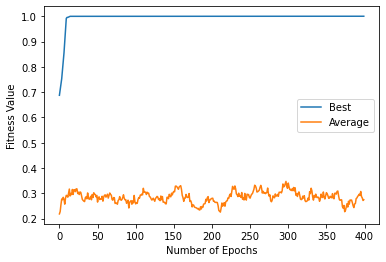

In [29]:
opt_ai_net = OptAiNet( 
                num_epochs=400,
                pop_size=20,
                Nc=10,
                chrom_length=2,
                clone_threshold=0.1,
                supression_threshold=0.2,
                newcomers_percentage=0.1,
                beta=100,
                value_ranges=[(-2,2), (-2,2)],
                fitness_func=roots_function
            )

best_solutions = opt_ai_net.fit()
opt_ai_net.plot()

Text(0.5, 0, 'z')

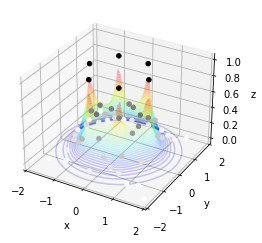

In [48]:
def schaffer_function_plot(x,y):
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

def roots_function_plot(x,y):
    z = x + 1j*y
    g = 1 / (1 + np.abs(z**6 - 1))
    return g

x_data = best_solutions[:, 0]
y_data = best_solutions[:, 1]
z_data = roots_function_plot(x_data, y_data)

x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)

X, Y = np.meshgrid(x, y)
Z = roots_function_plot(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='jet', alpha=0.2)
ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='binary', alpha=1)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


In [1]:
best_solutions.shape
print("teste")

NameError: name 'best_solutions' is not defined